## Download data

In [143]:
import os
from tqdm.notebook import tqdm, trange

import pandas as pd
import numpy as np

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Subset, Dataset
from torchsummary import summary

from sklearn.model_selection import train_test_split

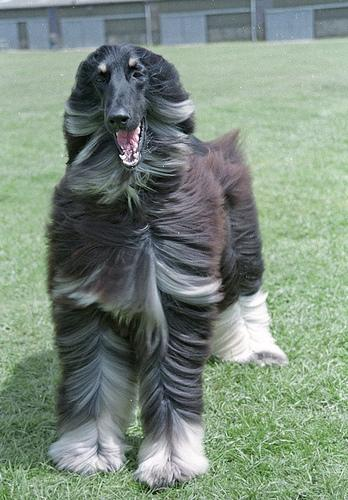

In [144]:
data = ImageFolder('data/')
display(next(iter(data))[0])

In [33]:
#GLOBAL PARAMETERS

num_epoch = 10
batch_size = 256
learning_rate = 0.001

## Train test split

In [148]:
train_indices, val_test_indices = train_test_split(
    range(len(data)), train_size=0.8, stratify=data.targets, random_state=42)

val_indices, test_indices = train_test_split(
    val_test_indices, train_size=0.8, random_state=42)

In [149]:
train_subset = Subset(data, train_indices)
val_subset = Subset(data, val_indices)
test_subset = Subset(data, test_indices)

In [150]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

In [152]:
# Задаём трансформеры
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.6),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}

In [153]:
train_dataset = MyDataset(train_subset, data_transforms['train'])
val_dataset = MyDataset(val_subset, data_transforms['val'])
test_dataset = MyDataset(test_subset, data_transforms['test'])
train_dataset.transform

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.6)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


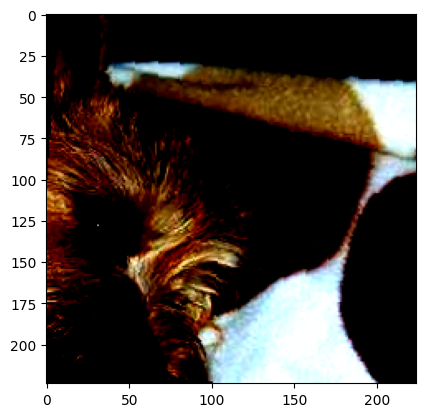

In [39]:
n = np.random.randint(0, 5000)
img = train_dataset[n][0].permute(1, 2, 0)
plt.imshow(img)

In [154]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=4,
    num_workers=0,
    shuffle=False
)

## Train/eval loop

In [155]:
def train_step(model, dataloader, loss_fn, optimizer, scheduler):
    # Training mode
    model.train()

    # loss, accuracy
    train_loss, train_acc = 0, 0

    # train loop for each batch
    for batch in tqdm(dataloader, leave=True, desc="Train iter:"):
        # batch to cuda()
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.cuda()

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = loss_fn(outputs, labels)

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backward
        loss.backward()  #backpropagation

        # optimizer step
        optimizer.step()

        # loss & accuracy for 1 batch

        train_loss += loss.item()  # Returns the value of this tensor as a standard Python number
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()

    # scheduler step
    scheduler.step()

    # loss & accuracy for 1 epoch
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_accuracy = train_acc / len(train_dataset)

    return epoch_train_loss, epoch_train_accuracy

In [156]:
def val_step(model, dataloader, loss_fn):
    # Evaluation mode
    model.eval()

    # loss, accuracy
    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        for batch in tqdm(dataloader, leave=True, desc="Val iter:"):
            # batch to cuda()
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.cuda()

            # forward pass
            outputs = model(inputs)

            # loss
            loss = loss_fn(outputs, labels)

            # loss & accuracy for 1 batch
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_acc += (predicted == labels).sum().item()

    # loss & accuracy for 1 epoch

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_acc / len(val_dataset)

    return epoch_val_loss, epoch_val_acc

In [157]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, epochs, writer=None):
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    pbar = trange(epochs, leave=True, desc='Epoch:')

    # train + val steps for every epoch
    for epoch in pbar:
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)

        pbar.set_description(f'Train loss: {train_loss:.4f}, train acc : {train_acc:.4f}. \
                               Val loss: {val_loss:.4f}, val acc : {val_acc:.4f}.')

        # save EVERY epoch(because)
        torch.save(model.state_dict(), f'epoch{epoch}_{model.name}.pth')

        # tensor board logging
        if writer is not None:
            writer.add_scalar('train_loss', np.array(train_loss), epoch)
            writer.add_scalar('train_acc', np.array(train_acc), epoch)
            writer.add_scalar('val_loss', np.array(val_loss), epoch)
            writer.add_scalar('val_acc', np.array(val_acc), epoch)
        writer.flush()

        # logging results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

        # save best weights
        if val_loss < min(results['val_loss']):
            torch.save(model.state_dict(), f'best_loss_{model.name}.pth')

    writer.close()
    return results

In [158]:
def plot_results(result: dict):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))

    ax[0].plot(result['train_loss'], label='train loss')
    ax[0].plot(result['val_loss'], label='val_loss')
    ax[0].legend()
    ax[1].plot(result['train_acc'], label='train_acc')
    ax[1].plot(result['val_acc'], label='val_acc')
    ax[1].legend()
    plt.show()

In [47]:
vit = torchvision.models.vit_l_16(
    weights=torchvision.models.ViT_L_16_Weights.DEFAULT)
vit.name = 'vit_l_16'

vit.heads.head = nn.Linear(in_features=1024, out_features=120, bias=True)
vit.load_state_dict(torch.load('epoch8_vit_l_16.pth'))

<All keys matched successfully>

In [111]:
testset = ImageFolder('dogs_test/pet classifer image directory', transform=data_transforms['val'])

## Create model

### Mobile Net v3

In [ ]:
# 9.83 MB
mob_net_V3 = torchvision.models.mobilenet_v3_large(
    weights=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT)
mob_net_V3.classifier

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 149MB/s]


Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# freeze some layers
for param in mob_net_V3.features.parameters():
    param.requires_grad = False

# modify classifier
mob_net_V3.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=120, bias=True)
)

mob_net_V3.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=120, bias=True)
)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mob_net_V3.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

mob_net_V3.name = 'mobile_net_large'

In [ ]:
mob_net_V3 = mob_net_V3.cuda()
writer = SummaryWriter(log_dir='logs',
                       comment=f'model/{mob_net_V3.name}_lr/{learning_rate}_frozen_layers/{0}_epoch/{num_epoch}')
mobile_net_res = train(model=mob_net_V3,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       loss_fn=loss,
                       optimizer=optimizer,
                       scheduler=scheduler,
                       epochs=2,
                       writer=writer)

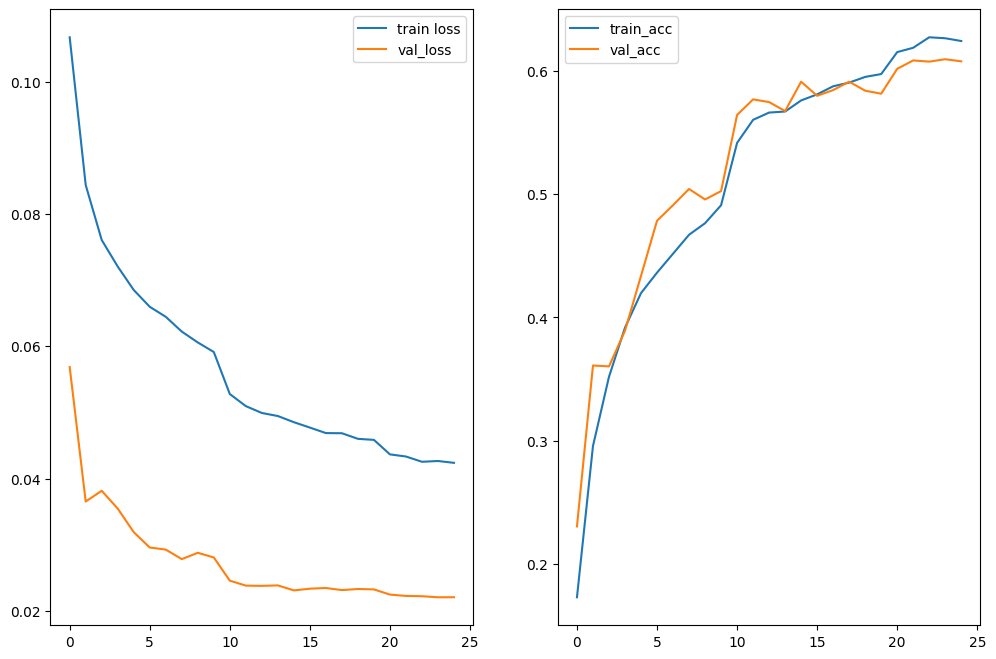

In [ ]:
plot_results(mobile_net_res)

### Efficient Net

In [51]:
#  загружаем pretrained модель (35.2)
eb7_model = torchvision.models.efficientnet_b7(
    weights=torchvision.models.EfficientNet_B7_Weights.DEFAULT)
eb7_model.name = 'efficientnet_b7'

# замораживаем часть слоёв, что бы не учить заново
for param in eb7_model.features.parameters():
    param.requires_grad = False

# меняем в классификаторе кол-во выходных классов
eb7_model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=2560, out_features=120, bias=True)
)
eb2_model = eb7_model.cuda()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eb7_model.parameters(), lr=learning_rate)
# каждые 5 эпохи уменьшаем lr на 50%
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
writer = SummaryWriter(log_dir='logs',
                       comment=f'eb7/{learning_rate}_frozen_layers/{0}_epoch/{num_epoch}_batch{batch_size}')
eb7_results = train(model=eb7_model,
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    loss_fn=loss,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epochs=100,
                    writer=writer
                    )

plot_results(eb7_model)

### ResNet50

In [ ]:
resnet = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.DEFAULT)
resnet.name = 'resnet50'
resnet.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

# замораживаем часть слоёв, что бы не учить заново
for param in resnet.parameters():
    param.requires_grad = False

# размораживаем слой классификатора
for param in resnet.fc.parameters():
    param.requires_grad = True

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

# каждые 3 эпохи уменьшаем lr на 50%
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

### Vizual Transformer

In [18]:
#1.3 Gb
vit = torchvision.models.vit_l_16(
    weights=torchvision.models.ViT_L_16_Weights.DEFAULT)
vit.name = 'vit_l_16'

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:06<00:00, 182MB/s]


In [19]:
# меняем в классификаторе кол-во выходных классов
vit.heads.head = nn.Linear(in_features=1024, out_features=120, bias=True)
vit.heads.head

Linear(in_features=1024, out_features=120, bias=True)

In [20]:
# замораживаем часть слоёв, что бы не учить заново
for param in vit.encoder.parameters():
    param.requires_grad = False

In [21]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=learning_rate)
# каждые 3 эпохи уменьшаем lr на 50%
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [22]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [25]:
vit = vit.cuda()

In [ ]:
writer = SummaryWriter(log_dir='logs',
                       comment=f'model/vit_lr/{learning_rate}_frozen_layers/{0}_epoch/{num_epoch}_batch{batch_size}')
vit_results = train(
    model=vit,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=num_epoch,
    writer=writer
)

plot_results(vit_results)

## Inference

In [159]:
vit = torchvision.models.vit_l_16(
    weights=torchvision.models.ViT_L_16_Weights.DEFAULT)
vit.name = 'vit_l_16'

vit.heads.head = nn.Linear(in_features=1024, out_features=120, bias=True)
vit.load_state_dict(torch.load('epoch8_vit_l_16.pth'))

<All keys matched successfully>

In [160]:
def one_image_predict(image):
    with torch.no_grad():
        vit.eval()
        image = torch.unsqueeze(image, dim=0)
        outputs = vit(image)
        probs = nn.functional.softmax(outputs, dim=-1).detach().numpy()

        pred = np.argmax(probs, axis=1)
        predict_label = data.classes[pred[0]]
        confidence = probs[0][pred][0]
    return predict_label, confidence

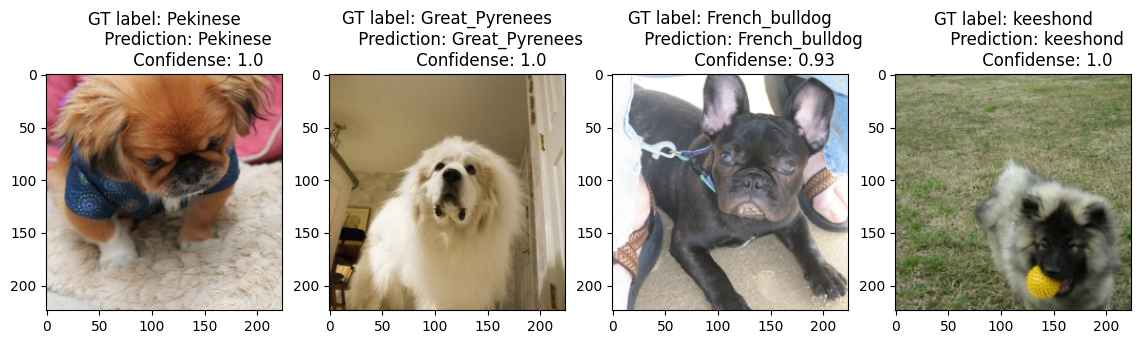

In [170]:
batch_size = 4
fig, ax = plt.subplots(figsize=(14, 8), nrows=1, ncols=4)
for i in range(batch_size):
    n = np.random.randint(0, len(test_dataset))
    gt_img = test_dataset[n][0]
    gt_label = test_dataset[n][1]
    predicted_label, confidence = one_image_predict(gt_img)
    conf = np.round(confidence, 2)
    ax[i].imshow(gt_img.permute(1, 2, 0))
    ax[i].set_title(f'GT label: {data.classes[gt_label]}\n \
        Prediction: {predicted_label}\n \
            Confidense: {str(conf)}')

In [218]:
model = vit
ground_truth = []
predicted = []
for batch in test_dataloader:
    images, gt_labels = batch
    with torch.no_grad():
        model.eval()
        outputs = model(images)
        probs = nn.functional.softmax(outputs, dim=-1).detach().numpy()
        pred = np.argmax(probs, axis=1)

        ground_truth.extend((gt_labels.tolist()))
        predicted.extend(pred)
to_df = {'Ground truth': ground_truth, 'Predicted': predicted}
df = pd.DataFrame(to_df)

<Axes: title={'center': 'ViT accuracy on test set'}>

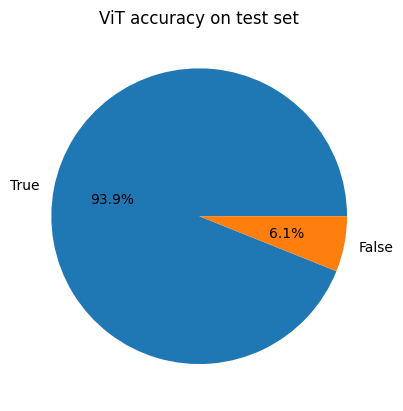

In [233]:
pie_series = df['Ground truth'] == df['Predicted']
pie_series.value_counts().plot(kind='pie', autopct='%1.1f%%', title='ViT accuracy on test set')